In [1]:
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import numpy as np

from sc_qubits import sc_qubits2 as qubit  # import the superconducting circuit module
from sc_qubits import plotting as plot 
import multiprocessing as mp
import time
from numpy import linalg as la
from functools import partial
import scipy.sparse as sp
#from scipy.sparse import linalg as la

from qutip import *
import os

from helper_functions.grape_functions import *
from main_grape.Grape_original import Grape
from helper_functions.qutip_open_verification import *
from helper_functions.qutip_mmt_verification import *
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Initialize 0-pi qubit parameters

In [2]:
T = 0.015
kb = 1.3806e-23
h = 6.626e-34
hbar = h / (2*np.pi)
beta = 1./(kb*T)
giga = 1e9

op = 2*np.pi*40
EJ_const = 0.25#0.165
ECJ_const = (1 / (8*EJ_const))
ECS_const = 0.001#0.00035
EL_const = 0.001

gate_coupling_theta = 1.0
gate_coupling_phi = 1.0

zero_pi_dim = 30

phitheta_grid = qubit.Grid(
    np.asarray([ 
        [-6*np.pi, 6*np.pi, 200], # phi variable
        [-np.pi/2, 3*np.pi/2, 200]   # theta variable (2pi periodic!)
    ])
    )
# Hamiltonian discritized in 2D phi-theta space (\ket{phi,theta}) (position space representation of states) 
symmetric_zero_pi = qubit.SymZeroPi(
    EJ = EJ_const,
    EL = EL_const,
    ECJ = ECJ_const,
    ECS = ECS_const,
    flux = 0.0,
    grid = phitheta_grid
)

symmetric_zero_pi_offset = qubit.SymZeroPiNg(
    EJ = EJ_const,
    EL = EL_const,
    ECJ = ECJ_const,
    ECS = ECS_const,
    flux = 0,
    ng = 0.25,
    grid = phitheta_grid
)

# # Hamiltonian discritized in 3D phi-theta-chi space (\ket{phi,theta,chi}) (dont really use this)
# disordered_zero_pi = qubit.fullZeroPi(
#     EJ
#     EL
#     ECJ
#     ECS
#     EC
#     dEJ
#     dCJ
#     dC
#     dEL
#     flux
#     grid
#     truncated_dim
# )

# Full Hamiltonian of 0pi coupled to chi mode via disorder in L and C



# Setup control Hamiltonian

[ 0.42572017  0.42659212  0.4536712   0.45440836  0.46792292  0.47748502
  0.47961906  0.48025439  0.49809003  0.49973754  0.50285405  0.50381849
  0.50663805  0.52109113  0.52580874  0.5263963   0.53150432  0.53335131
  0.53399166  0.53476835  0.53988419  0.54798701  0.55047489  0.55251182
  0.55909604  0.56205048  0.56335168  0.5715859   0.57269666  0.57303606]


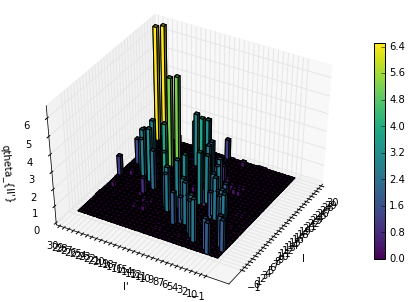

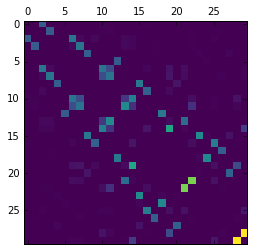

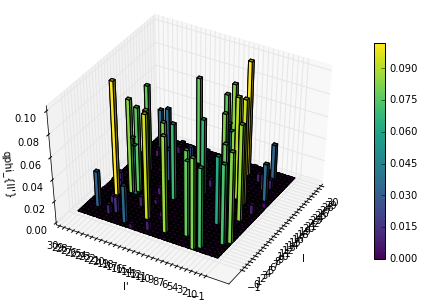

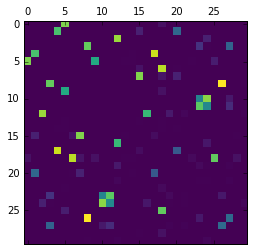

In [24]:
# evalulate charge matrix elements
symmetric_zero_pi.flux = 0.0
ev_count = zero_pi_dim
 
zeropi_evals, zeropi_states = symmetric_zero_pi._esys_calc(evals_count=ev_count)
print(zeropi_evals)
q_theta_mat = qubit.matrixelem_table(symmetric_zero_pi.i_d_dtheta_operator(), zeropi_states)
q_phi_mat = qubit.matrixelem_table(symmetric_zero_pi.i_d_dphi_operator(), zeropi_states)

plot.matrixelements(q_theta_mat, xlabel="l", ylabel="l'", zlabel="qtheta_{ll'}")
plot.matrixelements(q_phi_mat, xlabel="l", ylabel="l'", zlabel="qphi_{ll'}")

In [19]:
#reconstruct H
print (np.shape(zeropi_states))
print (np.shape(symmetric_zero_pi.i_d_dtheta_operator()))
print (len(zeropi_states))
for e in range (len(zeropi_states)):
    rr = np.reshape(zeropi_states[e],[len(zeropi_states[e]),1])
    H_rr = zeropinp.dot(rr,(np.transpose(np.conjugate(rr))))
    if e!=0:
        H_r = H_r + H_rr
    else:
        H_r = H_rr

print (np.shape(H_r))
print (H_r)

(40000, 30)
(40000, 40000)
40000
(30, 30)
[[  1.00000000e+00  -1.31853363e-14   3.19543596e-15   1.04021885e-15
    3.44415391e-15  -9.52526152e-16   2.18397609e-16   1.01619951e-16
   -1.52554670e-16  -2.30249211e-15  -4.80069956e-16  -4.68790577e-16
   -3.66761784e-16  -2.80367375e-16  -2.92215073e-16  -2.61741108e-16
   -1.57504793e-16   4.16635472e-17   3.52633255e-16  -3.21650410e-16
   -2.72517515e-16  -1.99592241e-16  -1.36137474e-17   1.57888126e-16
    5.64173523e-16  -5.35538136e-16  -3.36682653e-16  -7.12478290e-16
   -2.42301637e-16   5.21029727e-16]
 [ -1.31853363e-14   1.00000000e+00   9.23807297e-16  -4.18984466e-17
   -1.12057776e-15   6.55498864e-16   6.88955432e-16   6.55557210e-16
    4.25926100e-16   1.54840899e-15   1.50838465e-15   1.22030503e-15
    9.00180807e-16   4.12403031e-16   4.76833232e-16   2.66362547e-16
    3.91386765e-17  -1.00643425e-15  -1.09242349e-16   1.52890982e-16
    2.98905772e-16   4.04786215e-17  -3.30048402e-17   2.20137194e-17
    1.62642

In [4]:
myFile = open("dielectric_loss_rates.txt", "r")
myString = myFile.read()
myList = myString.split(',')
print (np.shape(myList))

myFile = open("dielectric_loss_rates.txt", "r")

lines = [line.rstrip('\n') for line in myFile]
print (np.shape(lines))
rates = [myString.split(',') for myString in lines]
print (np.shape(rates))
relevant_rates = []
c_ops = []
u = 10
l = 1
I = np.identity(zero_pi_dim)
upper = np.zeros(zero_pi_dim)
upper[u] = 1
lower = np.zeros(zero_pi_dim)
lower[l] = 1
lower = np.reshape(lower,[len(lower),1])
upper = np.reshape(upper,[len(upper),1])

c = I + np.dot(lower,np.transpose(upper)) - np.dot(upper,np.transpose(upper))

for ii in range (len(rates)):
    for jj in range (len(rates)):
        if float(rates[ii][jj]) > 1e-5:
            #print (rates[ii][jj],ii,jj)
            relevant_rates.append([ii,jj,rates[ii][jj]])
            I = np.identity(zero_pi_dim)
            u = ii
            l = jj
            upper = np.zeros(zero_pi_dim)
            upper[u] = 1
            lower = np.zeros(zero_pi_dim)
            lower[l] = 1
            lower = np.reshape(lower,[len(lower),1])
            upper = np.reshape(upper,[len(upper),1])

            c =  np.dot(lower,np.transpose(upper))
            c_ops.append(np.sqrt(float(rates[ii][jj])/40)*c)
print (len(relevant_rates))
print (len(c_ops))

(871,)
(30,)
(30, 30)
15
15


In [25]:


myFile = open("dielectric_loss_rates_dc_drive.txt", "r")

lines = [line.rstrip('\n') for line in myFile]
print (np.shape(lines))
rates = [myString.split(',') for myString in lines]
print (np.shape(rates))
relevant_rates = []
c_ops = []
u = 10
l = 1
I = np.identity(zero_pi_dim)
upper = np.zeros(zero_pi_dim)
upper[u] = 1
lower = np.zeros(zero_pi_dim)
lower[l] = 1
lower = np.reshape(lower,[len(lower),1])
upper = np.reshape(upper,[len(upper),1])

c = I + np.dot(lower,np.transpose(upper)) - np.dot(upper,np.transpose(upper))

for ii in range (len(rates)):
    for jj in range (len(rates)):
        if float(rates[ii][jj]) > 1e-5:
            #print (rates[ii][jj],ii,jj)
            relevant_rates.append([ii,jj,rates[ii][jj]])
            I = np.identity(zero_pi_dim)
            u = ii
            l = jj
            upper = np.zeros(zero_pi_dim)
            upper[u] = 1
            lower = np.zeros(zero_pi_dim)
            lower[l] = 1
            lower = np.reshape(lower,[len(lower),1])
            upper = np.reshape(upper,[len(upper),1])

            c =  np.dot(lower,np.transpose(upper))
            c_ops.append(np.sqrt(float(rates[ii][jj])/40)*c)
print (len(relevant_rates))
print (len(c_ops))

(30,)
(30, 30)
56
56


(5000,)
(1, 5000)
0.00086643936811


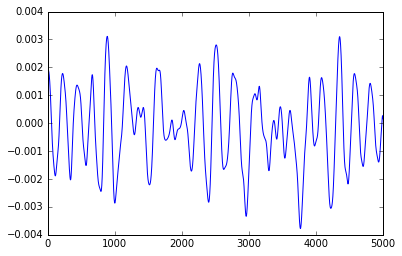

In [5]:

myFile = open("H_gate_pulse_data.txt", "r")

lines = [line.rstrip('\n') for line in myFile]
print (np.shape(lines))
pulse = [myString.split(',') for myString in lines]

pulse = np.reshape(pulse,[1,len(pulse)])
print (np.shape(pulse))
print (float(pulse[0][0]))
pulse = [float(p) for p in pulse[0]]
plt.plot(pulse)



## Optimal Control Interface:

(2000,)


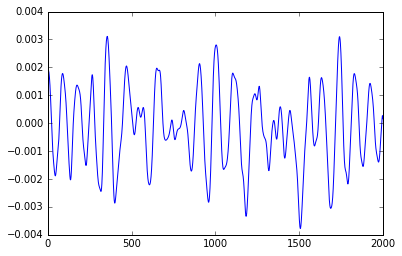

In [6]:
total_time = 5000
steps = 2000
x = np.linspace(0,total_time,steps)
xp = np.linspace(0,total_time,len(pulse))

fp = pulse

pulse2 = np.interp(x, xp, fp)
print (np.shape(pulse2))
plt.plot(pulse2)
uk0= [pulse2]

In [7]:
#Qutip

evals = np.load("eigenvalues.npy")

#print (evals)
#print (zeropi_evals)

print ([evals[i]-zeropi_evals[i] for i in range(len(evals)) if np.abs(evals[i]-zeropi_evals[i])>1e-10 ])

phi = np.load("phi_mat_elem.npy")

#print (phi-q_phi_mat)
myFile = open("time_data_X_gate.txt","r")

lines = [line.rstrip('\n') for line in myFile]

lines = [float(p) for p in lines]
#print (np.shape(lines))
#print (lines)
time = np.linspace(0,total_time,steps)
#print (time)
print ([time[ii]-lines[ii] for ii in range(len(time))])

[]
[0.0, 1.501050585304655, 3.0021011706093099, 4.5031517559139651, 6.0042023412186198, 7.5052529265232755, 9.0063035118279302, 10.507354097132584, 12.00840468243724, 13.509455267741895, 15.010505853046551, 16.511556438351203, 18.01260702365586, 19.513657608960514, 21.014708194265168, 22.515758779569822, 24.016809364874479, 25.517859950179137, 27.018910535483791, 28.519961120788448, 30.021011706093102, 31.522062291397752, 33.023112876702406, 34.524163462007067, 36.025214047311721, 37.526264632616375, 39.027315217921029, 40.528365803225682, 42.029416388530336, 43.530466973834997, 45.031517559139644, 46.532568144444312, 48.033618729748959, 49.534669315053605, 51.035719900358274, 52.53677048566292, 54.037821070967581, 55.538871656272228, 57.039922241576896, 58.540972826881543, 60.042023412186204, 61.543073997490858, 63.044124582795504, 64.545175168100172, 66.046225753404812, 67.54727633870948, 69.048326924014134, 70.549377509318788, 72.050428094623442, 73.551478679928096, 75.0525292652327

In [8]:

data_path = '../'

zeropi_hamiltonian = np.zeros(shape=(zero_pi_dim, zero_pi_dim))
for i in range(zero_pi_dim):
    zeropi_hamiltonian[i][i] = evals[i]

# these are the control operators, q_theta and q_phi
H_ops = [q_theta_mat]#, 
H_names = [b'theta']#,

states_concerned = [-1,-2,-3,-4]

mu = total_time*0.5
sigma = 0.15*total_time
alpha = 1.0 # ramp rate
chi = 0.025# strength
shift = 0.02
time = np.linspace(0,total_time,steps)
gaussian = chi*np.exp(-0.5*((time - mu)/(sigma))**2)
gaussian_phi = 0.8*np.exp(-0.5*((time - mu)/(sigma))**2)
ramp_phi = 10*chi*(1/(1+np.exp(-alpha*(time-shift*total_time))))*np.heaviside(-time + total_time*0.5,0.5) + 10*chi*(1/(1+np.exp(alpha*(time+shift*total_time-total_time))))*np.heaviside(time - total_time*0.5,0.5)
ramp = chi*(1/(1+np.exp(-alpha*(time-shift*total_time))))*np.heaviside(-time + total_time*0.5,0.5) + chi*(1/(1+np.exp(alpha*(time+shift*total_time-total_time))))*np.heaviside(time - total_time*0.5,0.5)
square = np.full((steps,1),0.5)
nothing = np.zeros(shape=(1,steps))
guess_pulse = [square]#,ramp_phi] # maybe use paper V_g and t_g
guess_pulse = [gaussian]
Ut_c = np.zeros(shape=(zero_pi_dim, zero_pi_dim))#la.expm(1j*total_time*zeropi_hamiltonian)
Ct_c = Ut_c.copy()
Ct_c[1,0] = 2**-0.5
Ct_c[0,1] = 2**-0.5
Ct_c[0,0] = 2**-0.5
Ct_c[1,1] = -2**-0.5
U = Ct_c

qubit_state_num = zero_pi_dim
#U =[]
#U1 = np.zeros(qubit_state_num,dtype=complex)
#U1[1]=1
#U1[0]=0
#U.append(U1)
#U2 = np.zeros(qubit_state_num,dtype=complex)
#U2[0]=1
#U.append(U2)

#Defining convergence parameters
max_iterations = 5000
decay = 1000
convergence = {'rate':0.001,'update_step':1,'max_iterations':max_iterations,\
               'conv_target':1e-4,'learning_rate_decay':decay}
max_a = [0.01]#0.0,100.0]

#Defining states to include in the drawing of occupation
states_draw_list = [0,1,2,3,4,5,6,7,8,9,10]
states_draw_names = ['0','1','2','3','4','5','6','7','8','9','10']
#forbidden_list = [12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29]

reg_coeffs = {'amplitude':75000.0,'dwdt':200000.0} #{'amplitude':0.0}
u0 = None
#c_ops = [0.0001*np.identity(qubit_state_num)]
#c_ops = [0.001*q_phi_mat]
uks, U_final=Grape(zeropi_hamiltonian,H_ops,H_names,U,total_time,steps,states_concerned,convergence=convergence,reg_coeffs=reg_coeffs,maxA=max_a,draw =[states_draw_list,states_draw_names],use_gpu=False,method = "Adam",file_name='symmetric_zero_pi',data_path = data_path,c_ops = c_ops,trajectories = 100, do_all_traj = False,initial_guess = uk0,show_plots=False)


TypeError: 'NoneType' object is not iterable

In [ ]:
#qutip
import qutip as qt
H0_qobj = qt.Qobj(zeropi_hamiltonian)
gate_time = total_time
gate_steps = steps
Hops_qobj = []

for Hop in H_ops:
    Hops_qobj.append(qt.Qobj(Hop))
            
            
cops_qobj = []

for cop in c_ops:
    cops_qobj.append(qt.Qobj(cop))
    # define time    
tlist = np.linspace(0,gate_time,gate_steps+1)
dt = float(gate_time/gate_steps)
uk0 = np.array(uk0)
uks_t0 = np.zeros((uk0.shape[0],1))
uks = np.hstack([uk0,uks_t0])

plt.plot(uks[0])
ini = np.zeros(zero_pi_dim)
ini[1] = 1
psi0 = qt.Qobj(ini)   
target = qt.Qobj(np.dot(U,ini))
        # make functions to return uks field
print (target)
def make_get_uks_func(id):
    def _function(t,args=None):
        time_id = int(t/dt)
        return uks[id][time_id]
    return _function
        
        # create the time-dependent Hamiltonian list
Ht_list = []
Ht_list.append(H0_qobj)
for ii in range(len(H_ops)):
    Ht_list.append([Hops_qobj[ii],make_get_uks_func(ii)])
            #us = np.asarray(np.reshape(uks[ii],[len(uks[ii])]))
            
            #Ht_list.append([Hops_qobj[ii],us])
        
opts = qt.Odeoptions(method='adams', nsteps=100000, atol=1e-3, rtol=1e-5)
        
        #args = {}
#output = mesolve(hamiltonian_JC, psi0, time_list, jump_op_list, [sm.dag()*sm, a.dag()*a, a, sm], args=args, options=me_options)
        
        # solving the Schrodinger evolution in QuTiP's sesolve
        #output = qt.sesolve(Ht_lst, psi0, tlist, [])
        
output = qt.mesolve(Ht_list, psi0, tlist, [],[psi0*psi0.dag(), target*target.dag()])
        
print (output.expect[1][-1])
print(output.expect[0])